## MNIST hand written data reconition

### import packages

In [15]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import time
import pickle
import matplotlib.pyplot as plt

### Data loading and pre-processing

#### we can learn that 
1. use np.empty(0, X) to create a numpy style placeholder
2. then use append to add data
3. create the random permutation labels for randomnize the data
4. the data is still 0 ~ 9 but the train and validation set are random permutated

In [44]:
mat = loadmat('mnist_all.mat')
# Dividing the data into training, test and Validation data
data_train=np.empty((0,784))
trn_lab=np.empty((0,1))
data_test=np.empty((0,784))
tes_lab=np.empty((0,1))
data_val=np.empty((0,784))
val_lab=np.empty((0,1))
for i in range(10):
    m1 = mat.get('test'+str(i))
    m2 = mat.get('train'+str(i))
    num1 = m1.shape[0]
    num2 = m2.shape[0]
    num3 = int(0.83342*num2)
    num4 = num2 - num3
    b = range(m2.shape[0])
    permut_b = np.random.permutation(b)
    Z1 = m2[permut_b[0:num3],:]
    Z2 = m2[permut_b[num3:],:]
    data_train = np.vstack([data_train,Z1])
    data_val = np.vstack([data_val,Z2])
    data_test = np.vstack([data_test,m1])
    for p in range(num3):
        trn_lab = np.append(trn_lab,i)
    for q in range(num4):
        val_lab = np.append(val_lab,i)
    for r in range(num1):
        tes_lab = np.append(tes_lab,i)
    # normalizing the data to values between to 0-1.
    data_test = data_test /255
    data_train = data_train / 255
    data_val = data_val / 255

#### Take a look at the data

In [39]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

In [40]:
mat['train0'].shape

(5923, 784)

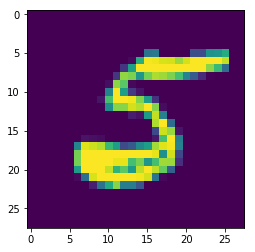

In [41]:
temppic = mat['train5'][100].reshape(28,28)
plt.imshow(temppic)
plt.show()

6


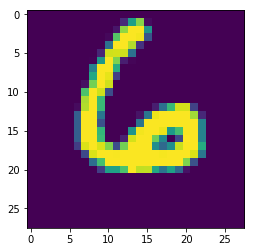

In [42]:
checkIDX = 33420
print (int(trn_lab[checkIDX]))
plt.imshow(data_train[checkIDX].reshape(28,28))
plt.show()

In [43]:
print (data_train.shape)
print (data_val.shape)
print (data_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)


In [67]:
#All check here
train_data = data_train
train_label = trn_lab
validation_data = data_val
validation_label = val_lab
test_data = data_test
test_label = tes_lab

print(train_data.shape)
print(train_label.shape) 

print(validation_data.shape)
print(validation_label.shape)

print(test_data.shape) 
print(test_label.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


## Start the CNN now

### There are 3 layers in total: input, hidden, output layers

In [68]:
# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]; 

# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 50;
				   
# set the number of nodes in output unit
n_class = 10;	

### Train the network first!

#### Weight initialization
Why we need the epsilon????

In [69]:
# initialize the weights into some random matrices
#W: matrix of random initial weights with size (n_out x (n_in + 1))"""
def initializeWeights(n_in,n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""
    
    #epsilon = sqrt(6) / sqrt(n_in + n_out + 1);
    #W = (np.random.rand(n_out, n_in + 1)*2* epsilon) - epsilon;
    # Why we need thing above?
    W = np.random.rand(n_out, n_in + 1)
    return W

initial_w1 = initializeWeights(n_input, n_hidden);
initial_w2 = initializeWeights(n_hidden, n_class);

#### get ready to use the weights

In [70]:
print (initial_w1.shape)
print (initial_w2.shape)

(50, 785)
(10, 51)


In [71]:
w1 = initial_w1
w2 = initial_w2
obj_val = 0

### To minimize the cost, we need proper define the cost function and its forms as 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

The objective function to be minimized. Must be in the form f(x, *args). The optimizing argument, x, is a 1-D array of points, and args is a tuple of any additional fixed parameters needed to completely specify the function.
args : tuple, optional
Extra arguments passed to the objective function and its derivatives (Jacobian, Hessian).

Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg, trust-krylov, trust-region-exact. If jac is a Boolean and is True, fun is assumed to return the gradient along with the objective function.

In [95]:
training_label = np.array(train_label)
rows = training_label.shape[0];
rowsIndex=np.arange(rows,dtype="int")

In [96]:
rowsIndex

array([    0,     1,     2, ..., 49997, 49998, 49999])

In [97]:
tempLabel = np.zeros((rows,10))
tempLabel[rowsIndex,training_label.astype(int)]=1

[ 0.  0.  0. ...,  9.  9.  9.]


In [113]:
training_label = tempLabel  #one hot key result of label

In [114]:
train_data.shape

(50000, 784)

In [115]:
training_data = np.column_stack((train_data,np.ones(train_data.shape[0])))

In [116]:
print (training_data.shape)
number_of_samples = training_data.shape[0]
print (number_of_samples)

(50000, 785)
50000


### Let it propagate and calculate the errors

In [117]:
def sigmoid(z):
    
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""
    sigmoid_result = 1.0 / (1.0 + np.exp(-1.0 * z));
    return  sigmoid_result

In [130]:
# passing the input data to the Hidden layer
zj = sigmoid(np.dot(training_data,w1.T))
print (zj.shape)
# adding bias to the hidden layer
zj = np.column_stack((zj,np.ones(zj.shape[0])))
print (zj.shape)
# passing the hidden layer data to the output layer
ol = sigmoid(np.dot(zj,w2.T))



(50000, 50)
(50000, 51)


In [119]:
# Back propogation
deltaOutput = ol - training_label
error = np.sum(-1*(training_label*np.log(ol)+(1-training_label)*np.log(1-ol)))
error = error/number_of_samples

### Calculate the gradient and backprapagation

In [121]:
deltaOutput = ol - training_label
error = np.sum(-1*(training_label*np.log(ol)+(1-training_label)*np.log(1-ol)))
error = error/number_of_samples

#### The above function is the cost function of logistic regression
https://www.coursera.org/learn/machine-learning/supplement/afqGa/cost-function

In [ ]:
gradient_of_w2 = np.dot(deltaOutput.T,zj)
gradient_of_w2 = gradient_of_w2/number_of_samples

#### The gradient of w2 is the delta times the zj (hidden layer values)
key elements here:
https://www.coursera.org/learn/machine-learning/supplement/pjdBA/backpropagation-algorithm

In [ ]:
gradient_of_w1 = np.dot(((1-zj)*zj* (np.dot(deltaOutput,w2))).T,training_data)
gradient_of_w1 = gradient_of_w1/number_of_samples	
gradient_of_w1 = np.delete(gradient_of_w1, n_hidden,0)

In [124]:
np.round(deltaOutput,2)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [-0.,  1.,  1., ...,  1.,  1.,  1.],
       [-0.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1., -0.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [126]:
ol[0]

array([ 0.99999984,  0.99999998,  0.99999991,  0.99999996,  0.99999982,
        0.99999992,  0.99999965,  0.9999999 ,  0.99999998,  0.99999992])

In [128]:
(1.001**3 - (1-0.001)**3)/0.002

3.0000009999998634

In [129]:
n_hidden

50